In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import numpy as np
import pandas as pd

import os

# from tqdm import tqdm, tqdm_notebook
import math


from scipy.optimize import curve_fit


# from  scipy.special import digamma as ψ
# from mpmath import besseli as Iν
# from scipy.constants import hbar, pi, h, e, k

# kB = k
# γ = 0.57721566
# RQ = h/4/e**2
# Φ0 = h/2/e

from JJformulas import *

# Notes on theory of JJ

The intention of this note is to summarize and organize the knowledge on the physics of single JJ, namely TA and Q phase diffusion, environment impedance influence, Bloch oscillations, etc  

## 1. RS(C)J-model

The simplest model considers current-biasing circuit consisted of Josephson element, Resistor and capasitor.

$I_s = I_c \sin \phi$

$\dot{\phi} = \frac{2 e}{ \hbar} V $

$ I_0 = \frac{\hbar C}{2e} \ddot{ \phi }  + \frac{\hbar}{ 2eR} \dot \phi + I_c \sin \phi $


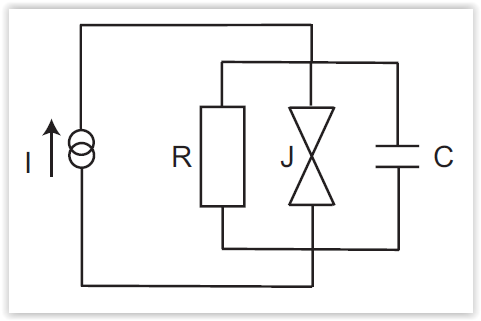
[Kopnin lecture]

$\omega_p = \sqrt{2eI_c/\hbar C} = \sqrt{8 E_J E_C}$ - plasma frequency

$Q = \omega_p R C$ - quality factor

### 1a) $C \rightarrow \infty $
Equvalent to underdamped regime ( $ 1/ \omega_p C \ll R $, $Q \gg 1$ ). Capacitence completely shunts josephson generation 

$$I_0 < I_c \Rightarrow I_s = I_0, I_R = 0, I_C = 0$$

$$I_0 > I_c \Rightarrow \overline{I_s + I_C} = 0, I_R = I_0$$

### 2a) $ C = 0$

Equvalent to overdamped regime ( $ 1/ \omega_p C \gg R $, $Q \ll 1$ )

For $I_0 > I_c$ Josephson current flows through resistor, so instantaneous voltage changes with time 

In [2]:
# t = np.linsapce(0, 5*2*np.pi, 101)
# Vinst = 

$ <I_s> = I_0 - <V>/R = I_0\left(1 - \sqrt{1 - \left( \frac{I_C}{I_0} \right)^2}\right)$

In [3]:
i = np.linspace(1, 5, 101)
Is = 1 - np.sqrt(1 - (1/i)**2)

plt.plot(i, Is)
plt.xlabel('${I_0}/{I_c}$')
plt.ylabel('${<I_s>}/{I_c}$')

FigureCanvasNbAgg()

Text(0, 0.5, '${<I_s>}/{I_c}$')

## IZ: Phase diffusion as Fokker-Plank process
[Zil'berman Ivanchenko JEPhT 24 6 1969](http://www.jetp.ac.ru/cgi-bin/dn/e_028_06_1272.pdf )



Note, that I-biased scheme with R||JJ is equvalent to V-biased with R and JJ in series

$ V_B = IR + \dot{ \phi } $  

$ \frac{V_B - IR}{R} =  \frac{\hbar C}{2e} \ddot{ \phi }  + I_c \sin \phi $

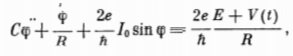

- underdamped limit $C \rightarrow 0$
- volage biasing scheme is equivalent to curernt-biasing with R as a shunt
- note the difference between $I-V_b$ and $I-V$ curves 

$$<I_s> = I_0 \Im \left( \frac{I_{1-2i\beta e V_B/ \hbar R_B}(\beta E_J)}{I_{-2i\beta e V_B/ \hbar R_B}(\beta E_J)} \right)$$

In [2]:
fig, ax = plt.subplots()

Vs = np.linspace(0, 1e-4, 501)

R_list = [1e2, 1e3, 5e3]



EJ = 0.05
kT = .02

for R in R_list:
    Is =      I_IZ     ( Vs, EJ = EJ, R = R, T = kT)
    Is_simp = I_IZ_simp( Vs, EJ = EJ, R = R, T = kT)

# ax.plot(  Vs/1e-3, Is/1e-9, '--', label = r'$I-V_b$')
    ax.plot( (Vs - Is*R) /1e-6, Is/1e-9, label = f'{R/1e3} kOhm' )
#     ax.plot( (Vs ) /1e-3, Is_simp/1e-9, '--' )

ax.set_xlabel(r'$V, uV$')
ax.set_ylabel(r'$I, nA$')


# ax.set_xlim(0, .1e-3)
# ax.set_xscale ('log')
ax.legend()



ax.set_title('EJ = {:g} K, T = {:g} K'.format(EJ, kT))

FigureCanvasNbAgg()

Text(0.5, 1.0, 'EJ = 0.05 K, T = 0.02 K')

The idea is that the noise on the capacitance C produces gaussian-distributed voltage with width $\sigma = \sqrt{E_c k T} $. In order to get new IVC let's convolute the old one with gaussian distribution

In [11]:
from scipy import interpolate

fig, ax = plt.subplots(figsize = (4,5))

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

Rsh = 377

kT = 0.050
Ec = 1
EJ = 0.4
Vc_noise = np.sqrt(2*Ec*kT)/1e4


Npts = 501
V_ = np.linspace(-1e-3, 1e-3, Npts)/1e1


def IZ_conv(V_, EJ, Vc_noise, kT, Rsh):
    
    sigma = Vc_noise#np.sqrt(Ec*kT)/1e4
    Is = I_IZ( V_, EJ = EJ, R = Rsh, T = kT)

    Vs = V_ - Is*Rsh

    f = interpolate.interp1d(Vs, Is)




    Vs_evengrid = np.linspace(np.min(Vs), np.max(Vs), len(Vs))
    
    dVs =  (np.max(Vs) - np.min(Vs)) / (len(Vs)-1)
    
    

    Is_evengrid = f(Vs_evengrid)

    Is = Is_evengrid
    Vs = Vs_evengrid

    V_c = gaussian(Vs, 0, sigma)*dVs

    Is_conv = np.convolve(Is, V_c, 'same')
#     print(len(Is))
    
    return Vs, Is, Is_conv

Vs, Is, Is_conv = IZ_conv(V_, EJ, Vc_noise, kT, Rsh)


# ax.plot(Vs/1e-6, Is/1e-9, 'o', label = 'cIZ')

ax.plot(Vs/1e-6 ,Is_conv/1e-9, label = 'cIZ + Vnoise')



ax.set_xlabel('V, uV')
ax.set_ylabel('I, nA')

ax.set_title('EJ = {:g} K, T = {:g} K, Rb = {:g} Ohm'.format(EJ, kT, Rsh))

# ax.set_xlim(0, 300)
# ax.set_ylim(0, .0250)

ax.legend()

plt.tight_layout()

FigureCanvasNbAgg()

In [123]:
Iν(1j, 7/0.05)

mpc(real='2.1429859019146757e+59', imag='4.4853298352534639e+39')

In [98]:
np.sqrt(2*2.5*.02)

0.31622776601683794

In [199]:
7/20*10

3.5

In [11]:


Rsh = 377

kT = 0.5
# Ec = 10
Vc_noise = 50e-6

EJ_list = np.logspace(-2,1.5, 51)

Npts = 251
V_ = np.linspace(-1e-3, 1e-3, Npts)

Isws = []
Isws_conv = []

R0s = []
R0s_conv = []

for EJ in EJ_list:
    Vs, Is, Is_conv = IZ_conv(V_, EJ, Vc_noise , kT, Rsh)
    
#     Isw = (np.max(Is) - np.min(Is))/2
#     Isw_conv = (np.max(Is_conv) - np.min(Is_conv))/2
    
    Imax = np.max(Is)
    Imax_conv = np.max(Is_conv)

    Vmax = Vs[np.argmax(Is)]
    Vmax_conv = Vs[np.argmax(Is_conv)]
    
    R0s.append( Vmax/Imax )
    R0s_conv.append( Vmax_conv/Imax_conv )
    
    
    
    Isws.append(Imax)
    Isws_conv.append(Imax_conv)
    

    


In [9]:
ft = pd.read_excel("chain table.xlsx", index_col = 0)

ft

,Vo_tot,Rn_tot,Isw,Ro_tot,RoFF,N,Npar,dsgn,Ajj,status,Rn,Ro,Ec,Ej,Iab,wp
D055B1N9,219.0u,121.0k,154.0p,905.0k,666.8M,20,2,Fin,40.0f,measd_lv,6.0k,45.2k,185.9m,1.1,47.0n,1.3
D059B6N3,195.5u,90.8k,2.0n,72.6k,25.9M,20,2,Fin,40.0f,measd_lv,4.5k,3.6k,185.9m,1.5,62.6n,1.5
D059B0N1,320.0n,9.4k,3.9n,99.7,1.6G,2,2,Fin,40.0f,measd_lv,4.7k,49.8,185.9m,1.4,60.5n,1.5
D059BBN2,1.4m,1.8M,320.0f,236.7M,903.2M,20,2,Fin,40.0f,fabd,87.5k,11.8M,185.9m,77.4m,3.2n,339.4m
D062B3N2,2.5m,993.0k,21.0p,4.3M,893.1M,20,2,Fin,40.0f,fabd,49.6k,216.0k,185.9m,136.5m,5.7n,450.5m
D060B2N6,3.3m,664.0k,1.2p,22.9M,958.7M,20,2,Fin,40.0f,fabd,33.2k,1.1M,185.9m,204.1m,8.6n,551.0m
D060B2N2,318.6u,119.0k,2.7p,29.1M,920.9M,4,2,Fin,40.0f,fabd,29.8k,7.3M,185.9m,227.8m,9.6n,582.0m
D063BAN6_b,5.0m,594.0k,20.0p,7.7M,935.0M,30,2,x_s,40.0f,fabd,19.8k,257.2k,185.9m,342.2m,14.4n,713.4m
D063BAN6_a,3.1m,585.0k,22.0p,265.0k,13.8M,30,2,x_s,4.0p,fabd,19.5k,8.8k,2.3m,347.5m,14.6n,79.4m
D066B8N5_b,1.7m,66.1k,5.4n,851.0,146.3M,30,2,x_s,40.0f,fabd,2.2k,28.4,185.9m,3.1,129.0n,2.1


In [5]:
import sys 
sys.path.append('..\measDC\_jjtools')

# from Exps import *

from JJ_data_processing import read_opj_data, pbi, bpbi, show_df, update_df
from JJ_data_processing import xy_by_id,extract_Isw_R0_by_id


from JJformulas import *
from meas_util import *

from JJmeasurement import *

D:\anaconda\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'
D:\anaconda\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
import os

jj = JJmeas(sample = 'D070B1N5v1')

jj.db_connect()
jj.ZF   = -0.093e-3
jj.FF   = 0.130e-3



In [7]:
B_list = np.linspace(-.4e-3, .2e-3, 121)

ZF   = -0.093e-3
FF   = 0.130e-3
 
cos_list = abs (np.cos(np.pi/2 *(B_list - ZF)/(FF - ZF)))

ids = range(689,809+1)

Ics_n5 = [2*extract_Isw_R0_by_id (idx, dy = 30e-6)[0] for idx in ids]
R0s_n5 = [1/15*extract_Isw_R0_by_id (idx, dy = 30e-6)[1] for idx in ids]

Ejs_n5 = 0.412*cos_list


fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
ax1.plot(cos_list, Ics_n5, 'o-')

# fig, ax = plt.subplots()
ax2.plot(cos_list, R0s_n5, 'o')
ax2.set_yscale('log')

ax1.set_ylabel('Isw, pA')
ax2.set_ylabel('R0, Ohm')

ax2.set_xlabel('cos')

e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJ_data_processing.py:285: RuntimeWarning: invalid value encountered in less
  ind1 = np.where(np.abs(vA0) < dx )


FigureCanvasNbAgg()

Text(0.5, 0, 'cos')

In [8]:
#fig, ax = plt.subplots()    

# ft = pd.read_excel("chain table.xlsx")

colormap = { 'D05' : 'C0', 'D06' : 'C1'}

ax = ft.plot( x = 'Ej', y = 'Isw', color ='k', marker = 'D', ls = '')

for dev_name in ft.index:
#     print(dev_name)
    dev = ft.loc[dev_name]
#         dev = ft.loc[dev_name]
    text = '{:d}_{}'.format(dev['N'],dev_name)
#     ax.annotate( text, ( dev['Ej'], dev['Isw']), color = colormap.get(dev_name[:3], 'C2'))

#     ax.annotate( text, ( dev['Ej'], dev['Isw']), color = colormap.get(dev_name[:3], 'C2'))
   


# for dev_name in ft.index:
#     dev = ft.loc[dev_name]
# #     text = '{:d}_{}'.format(dev['N'],dev_name)
#     ax.annotate( text, ( dev['Ej'], dev['Isw']), color = colormap.get(dev_name[:3], 'C2'))
    
ax.set_xscale('log')
ax.set_yscale('log')

x, y = np.loadtxt('78N0.out')

n = 20
# ax.plot(x[:n],y[:n], 'o')



ax.plot(EJ_list, Isws, label = 'cIZ')
ax.plot(EJ_list, Isws_conv, label = 'cIZ + Vc_noise')

ax.set_xscale('log')
ax.set_yscale('log')


# ax.plot(EJ0_exp, IcIAB_exp * EJ0_exp*kB/hbar*2*e, 'o')

ax.plot(EJ_list,  EJ_list*kB/hbar*2*e, '--', label = '$A-B$')


ax.plot(Ejs_n5, Ics_n5, 'o-', label = 'D070B1 N5')

ax.plot(Ejs_79, Ics_79, 'o-', label = 'D079 N5')

ax.legend()

ax.set_xlabel('EJ, K')
ax.set_ylabel('Isw, A')

ax.set_title('Vc_noise = {:g} uV, T = {:g} K, Rb = {:g} Ohm'.format( Vc_noise*1e6, kT, Rsh))



ax.plot([55e-3], [0.6e-12], marker = 's')

ax.set_xlim(10e-3, 2)


#fig, ax = plt.subplots()

ax = ft.plot( x = 'Ej', y = 'Ro', color ='k', marker = 'D', ls = '')

ax.plot(EJ_list, R0s, label = 'cIZ')
ax.plot(EJ_list, R0s_conv, label = 'cIZ + Vc_noise')

ax.plot(Ejs_n5, R0s_n5, 'o-', label = 'D070B1 N5')
ax.plot(Ejs_79, R0s_79, 'o-', label = 'D079 N5')

for dev_name in ft.index:
    dev = ft.loc[dev_name]
    text = '{:d}_{}'.format(dev['N'],dev_name)
#     ax.annotate( text, ( dev['Ej'], dev['Ro']), color = colormap.get(dev_name[:3], 'C2'))

# ax.plot(EJ0_exp, R0_exp, 'o')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('EJ, K')
ax.set_ylabel('R0, Ohm')

ax.set_title('Vc_noise = {:g} uV, T = {:g} K, Rb = {:g} Ohm'.format( Vc_noise*1e6, kT, Rsh))



ax.legend()




NameError: name 'ft' is not defined

In [13]:
jj79 = JJmeas(sample = 'D079N5')

jj79.db_connect()

cos_list_79 = np.linspace(1, 0, 51 )
Ejs_79 = 4.14*cos_list_79


ids = range(72,122+1)

Ics_79 = [2*extract_Isw_R0_by_id (idx, dy = 30e-6)[0] for idx in ids]
R0s_79 = [1/15*extract_Isw_R0_by_id (idx, dy = 30e-6)[1] for idx in ids]


# fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
# ax1.plot(cos_list, Ics, 'o-')

# # fig, ax = plt.subplots()
# ax2.plot(cos_list, R0s, 'o')
# ax2.set_yscale('log')
# ax1.set_yscale('log')

D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
jj74 = JJmeas(sample = 'D074N3')

jj74.db_connect()

cos_list_74 = np.linspace(1, 0, 51 )
Ejs_74 = 0.185*cos_list_74


ids = range(  43,   93+1)

Ics_74 = [2*extract_Isw_R0_by_id (idx, dy = 30e-6)[0] for idx in ids]
R0s_74 = [1/15*extract_Isw_R0_by_id (idx, dy = 30e-6)[1] for idx in ids]


# fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
# ax1.plot(cos_list, Ics, 'o-')

# # fig, ax = plt.subplots()
# ax2.plot(cos_list, R0s, 'o')
# ax2.set_yscale('log')
# ax1.set_yscale('log')

In [63]:
jj74.bpbi(ids)

e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJ_data_processing.py:165: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


FigureCanvasNbAgg()

No handles with labels found to put in legend.


In [21]:
2*6.64e-34/4/(1.6e-19)**2/0.074

175253.37837837837

In [ ]:
fig, ax = plt.subplots()


ax.plot(EJ0_exp, R0_exp* IcIAB_exp * EJ0_exp*kB/hbar*2*e, 'o')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('EJ, K')
ax.set_ylabel('R0*Isw, V')

In [15]:


Rsh = 377

kT = 0.05
Ec = 1
Vc_noise = 10e-6

EJ = 0.6/4

kT_list = np.linspace(.02,.22, 51)

Npts = 251
V_ = np.linspace(-1e-3, 1e-3, Npts)

Isws = []
Isws_conv = []

R0s = []
R0s_conv = []

for kT in kT_list:
    
    Vc_noise = np.sqrt(Ec*kT)/1e4
    print(Vc_noise)
    Vs, Is, Is_conv = IZ_conv(V_, EJ, Vc_noise , kT, Rsh)
    
#     Isw = (np.max(Is) - np.min(Is))/2
#     Isw_conv = (np.max(Is_conv) - np.min(Is_conv))/2
    
    Imax = np.max(Is)
    Imax_conv = np.max(Is_conv)

    Vmax = Vs[np.argmax(Is)]
    Vmax_conv = Vs[np.argmax(Is_conv)]
    
    R0s.append( Vmax/Imax )
    R0s_conv.append( Vmax_conv/Imax_conv )
    
    
    
    Isws.append(Imax)
    Isws_conv.append(Imax_conv)
    
Isws = np.array(Isws)
Isws_conv = np.array(Isws_conv)

R0s = np.array(R0s)
R0s_conv = np.array(R0s_conv)


1.4142135623730951e-05
1.5491933384829667e-05
1.673320053068151e-05
1.7888543819998316e-05
1.897366596101028e-05
2e-05
2.097617696340303e-05
2.1908902300206645e-05
2.280350850198276e-05
2.3664319132398465e-05
2.449489742783178e-05
2.5298221281347034e-05
2.60768096208106e-05
2.683281572999748e-05
2.7568097504180444e-05
2.8284271247461902e-05
2.8982753492378878e-05
2.966479394838265e-05
3.0331501776206206e-05
3.0983866769659334e-05
3.1622776601683795e-05
3.22490309931942e-05
3.286335345030997e-05
3.346640106136302e-05
3.405877273185281e-05
3.464101615137755e-05
3.521363372331802e-05
3.577708763999663e-05
3.63318042491699e-05
3.687817782917155e-05
3.741657386773941e-05
3.794733192202055e-05
3.847076812334269e-05
3.8987177379235857e-05
3.9496835316262994e-05
4e-05
4.049691346263318e-05
4.098780306383839e-05
4.147288270665544e-05
4.195235392680606e-05
4.242640687119285e-05
4.289522117905443e-05
4.33589667773576e-05
4.381780460041329e-05
4.427188724235731e-05
4.4721359549995795e-05
4.5166359

In [16]:
fig, ax = plt.subplots()    
    
# ax.plot(kT_list, Isws, label = 'cIZ')
ax.plot(kT_list, Isws_conv)

# ax.set_xscale('log')
# ax.set_yscale('log')




ax.legend()

# ax.set_xlabel('EJ, K')
# ax.set_ylabel('Isw, A')

ax.set_title('T = {:g} K, Rb = {:g} Ohm'.format( kT, Rsh))



fig, ax = plt.subplots()

ax.plot(kT_list, R0s)
ax.plot(kT_list, R0s_conv)

# ax.plot(EJ0_exp, R0_exp, 'o')

#     ax.set_xscale('log')
#     ax.set_yscale('log')



fig, ax = plt.subplots()

# ax.plot(kT_list, Isws*R0s)
ax.plot(kT_list, Isws_conv*R0s_conv)

FigureCanvasNbAgg()

No handles with labels found to put in legend.


FigureCanvasNbAgg()

FigureCanvasNbAgg()

In [7]:
data = np.genfromtxt(os.getcwd()+ f'\IcvsEJ.dat')
IcIAB_exp = data[:, 2]
EJ0_exp   = data[:, 0]
EJ0_exp

array([8.13031, 0.65602, 0.36831, 0.1087 , 0.04361])

In [9]:
data = np.genfromtxt(os.getcwd()+ f'\R0vsEJ.dat')
R0_exp  = data[0:, 3]
EJ0_exp = data[0:, 2]/2
EJ0_exp

array([8.130315, 0.656025, 0.368315, 0.1087  , 0.04361 ])

In [68]:
fig, ax = plt.subplots()

ax.plot(EJ0_exp, IcIAB_exp * EJ0_exp*kB/hbar*2*e, 'o')

ax.plot(EJ_list, Isws)
ax.plot(EJ_list, Isws_conv)

ax.set_xscale('log')
ax.set_yscale('log')

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


FigureCanvasNbAgg()

In [3]:
fig, ax = plt.subplots()

Vs = np.logspace(-5, -2, 501)

# R_list = [1e3, 20e3, 12e3]

R_list = [ 1e3]

for R in R_list:
    Is = I_IZ( Vs, EJ = .5, R = R, T = .05)
    
    ind = np.where (np.diff (Is ) / np.diff (Vs - Is*R) >0)

#     print(ind)
    Is, Vs = Is[:-1][ind], Vs[:-1][ind]

# ax.plot(  Vs/1e-3, Is/1e-9, '--', label = r'$I-V_b$')
    ax.plot( Is/1e-9,(Vs - Is*R) /1e-3,  label = f'{R/1e3} kOhm' )
    
    
    
    V_fit = lambda x, A,B  : A*np.sinh(x*B )
    popt1 = ( 1e-3 , 1e-3)
    popt, pcov = curve_fit(V_fit, Is/1e-12 ,(Vs - Is*R)/1e-6, p0 = popt1 )

    Vf = V_fit(Is/1e-12, *popt)*1e-6
    ax.plot(Is/1e-9, Vf/1e-3,'--' )
    
ax.set_ylabel(r'$V, mV$')
ax.set_xlabel(r'$I, nA$')


# ax.set_xlim(0, .1e-3)
# ax.set_xscale ('log')
ax.legend()


FigureCanvasNbAgg()

In [4]:
fig, ax = plt.subplots()

Ic = 35e-9

Vs = np.logspace(-5, -2, 501)
# Vs = np.linspace(0, 1e-2, 501)

R = 1e3

T_list = np.linspace(0.05, 0.5, 21)
As = []
Bs = []


Ims =[]
for T in T_list:

    Is = I_IZ( Vs, EJ = 1.25, R = R, T = T)
    
    ind = np.where (np.diff (Is ) / np.diff (Vs - Is*R) >0)

#     print(ind)
    Is, Vs = Is[:-1][ind], Vs[:-1][ind]


    Ims.append(Is[np.argmax(Vs)])
    
    ax.plot( Is/1e-9,(Vs - Is*R) /1e-3,  label = f'{R/1e3} kOhm' )

    V_fit = lambda x, A,B  : A*np.sinh(x*B )
    popt1 = ( 1e-3 , 1e-3)
    popt, pcov = curve_fit(V_fit, Is/1e-12 ,(Vs - Is*R)/1e-6, p0 = popt1 )

    Vf = V_fit(Is/1e-12, *popt)*1e-6
    ax.plot(Is/1e-9, Vf/1e-3,'--' )
    
    A, B = popt[0], popt[1]
    
    As.append(A)
    Bs.append(B)

 

    # ax.plot(  Vs/1e-3, (Is - Vs/R)/1e-9, label = r'$I_s - V$')


#     ax.set_xlabel(r'$V, mV$')
#     ax.set_ylabel(r'$I, nA$')

    print(popt)

# ax.legend()

# Bs = np.array(Bs)
# ax.plot(T_list, As)

# # ax.set_xscale('log')
# # ax.set_yscale('log')
# ax2 = ax.twinx()
# ax2.plot(T_list, Bs/T_list, c = 'C1')

# ax2.set_yscale('log')

# fig, ax = plt.subplots()
# ax.plot(T_list, Ims, 'o-')

FigureCanvasNbAgg()

[-4.00052445e-18  1.00000000e-03]
[1.65752614e-13 7.55186412e-04]
[1.68236302e-11 6.79468426e-04]
[6.47292942e-09 5.53981127e-04]
[1.25960884e-07 4.98414403e-04]
[1.51275530e-06 4.49594141e-04]
[1.19719013e-05 4.07486618e-04]
[6.70457265e-05 3.71427055e-04]
[0.00028339 0.00034057]
[0.00095343 0.00031413]
[0.00266359 0.00029142]
[0.00638713 0.0002719 ]
[0.01349824 0.00025511]
[0.02569004 0.00024066]
[0.04483147 0.00022821]
[0.07282247 0.00021745]
[0.11148186 0.0002081 ]
[0.16247884 0.00019994]
[2.27293248e-01 1.92770838e-04]
[3.07199671e-01 1.86443894e-04]
[4.03256137e-01 1.80831324e-04]


In [5]:
fig, ax = plt.subplots()

ax.plot(T_list, Ims, 'o-')

FigureCanvasNbAgg()

In [6]:
fig, ax = plt.subplots()

Bs = np.array(Bs)
ax.plot(T_list, As, 'o-')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax2 = ax.twinx()
ax2.plot(T_list, Bs/T_list, 'o-', c = 'C1')

# ax2.set_yscale('log')



FigureCanvasNbAgg()

In [7]:

R_env_list = np.logspace(2, 5, 51)



EJ = 0.15
T =  0.05

fig, ax = plt.subplots()
ax2 = ax.twinx()

for EJ in [0.15, 0.25, 0.35]:

    R0s  = []
    Isws = []

    for R_env in R_env_list:

        R0, Isw = find_R0_Isw( EJ, R_env , T, VERBOSE = False)
        R0s.append(R0)
        Isws.append(Isw)


    ax.plot(R_env_list, R0s, label = f'EJ = {EJ} K')




    ax2.plot(R_env_list, Isws, '--')
    
ax.legend()    

ax.set_xscale ('log')
ax.set_yscale ('log')

ax2.set_yscale ('log')


FigureCanvasNbAgg()

In [8]:

EJ_list = np.logspace(-2, 1, 51)



# R_env = 0.15
T =  0.05

fig, ax = plt.subplots()
ax2 = ax.twinx()

for R_env in [1e3, 1e5]:

    R0s  = []
    Isws = []

    for EJ in EJ_list:

        R0, Isw = find_R0_Isw( EJ, R_env , T, VERBOSE = False)
        R0s.append(R0)
        Isws.append(Isw)


    ax.plot(EJ_list, R0s, label = f'Renv = {R_env/1e3} kOhm')
    
    Ics = EJ_list/(Φ0/2/pi/kB)
    ax2.plot(EJ_list, Ics, '--')


#     ax2 = ax.twinx()
    Isws = np.array(Isws)
    ax2.plot(EJ_list, Isws/EJ_list, '--')
    
ax.legend()    

ax.set_xscale ('log')
ax.set_yscale ('log')

ax2.set_yscale ('log')


FigureCanvasNbAgg()

## 3. Phase diffusion as Fokker-Plank process -2
[Ambegaokar-Halperin PRL 22 25 1969](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.22.1364 )



- The same Fokker-Planck eq with non-zero $C$, overdamped limit $\eta = 1/RC \gg 1$
- Attempt frequency is $\omega_J^2 / 2 \pi \eta =  \omega_J / \beta_C$
- Derived for I-biased regime
- Note the difference between the total current through R||JJ and pure supercurrent

In [2]:
fig, ax = plt.subplots()

Ic = 3e-9

Is = np.linspace(0, 1.5*Ic, 501)

R = 1

# T_list = np.linspace(0.05, 0.5, 11)
T_list = [0.02]

As = []
Bs = []


Ims =[]
for T in T_list:

    Vs = V_AH_star( Is, EJ =0.051, Rn = R,  T = T)

    ind = np.where (np.diff (Vs ) >0)

    Is, Vs = Is[:-1][ind][:-10], Vs[:-1][ind][:-10]

    Ims.append(Is[np.argmax(Vs)])
    
    ax.plot(   Is/1e-9, Vs/1e-3, label = r'$I_b - V$')


    V_fit = lambda x, A,B  : A*np.sinh(x*B )
    popt1 = ( 1e-3 , 1e-3)
    popt, pcov = curve_fit(V_fit, Is/1e-12 ,Vs/1e-6, p0 = popt1 )

    Vf = V_fit(Is/1e-12, *popt)*1e-6
    
    A, B = popt[0], popt[1]
    
    As.append(A)
    Bs.append(B)

    ax.plot(Is/1e-9, Vf/1e-3,'--' )


    # ax.plot(  Vs/1e-3, (Is - Vs/R)/1e-9, label = r'$I_s - V$')


#     ax.set_xlabel(r'$V, mV$')
#     ax.set_ylabel(r'$I, nA$')

    print(popt)

# ax.legend()

# Bs = np.array(Bs)
# ax.plot(T_list, As)

# # ax.set_xscale('log')
# # ax.set_yscale('log')
# ax2 = ax.twinx()
# ax2.plot(T_list, Bs/T_list, c = 'C1')

# ax2.set_yscale('log')

# fig, ax = plt.subplots()
# ax.plot(T_list, Ims, 'o-')

FigureCanvasNbAgg()

e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:167: RuntimeWarning: invalid value encountered in sqrt
  i_ = (1 - i**2)**0.5
e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:169: RuntimeWarning: invalid value encountered in arcsin
  return 2*Ic0*Rn* i_ * np.exp( -Γ*( i_ + i*np.arcsin(i) ))*np.sinh(np.pi/2*Γ*i)
D:\anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


[-0.00011008 -0.00165937]


## 4. Phase diffusion as activation process 
Kautz Martinis

### 4a. Thermally activated PD

# Coulomb at P(E)

## $E_J$ renormalization

In the limit $E_J \ll E_C$ and high-resistive environment a probability of CP tunneling is quadratic in $E_J$ and effective $E_J$ can be calculated ([Mesoscopic Josephson Effect Superlatt. Microstruct. 25, 915 (1999)](https://www.physik.uni-augsburg.de/theo1/ingold/publikationen_coll/grabe99/grabe99.pdf) )


In [12]:
Renv_list = np.logspace(2, 6, 101)

RN = 10e3


Cj_list = [1e-15, 1.5e-15, 2e-15]
fig, ax1 = plt.subplots()

for Cj in Cj_list:
    EJs = EJ_star (EJ = EJ_AB(RN), R = Renv_list, T = .03, C = Cj)

    ax1.plot( Renv_list , EJs, label = r'C = {:1.2f} fF'.format(Cj/1e-15 ))

# ax1.plot( Renv_list , EJ_AB(RN), '--k', alpha = 0.5)
ax1.axhline(EJ_AB(RN), 0 , 1, ls = '--', color = 'k', alpha = 0.5)


ax1.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$R_{env}, K$')
ax1.set_ylabel(r'$E_J^*, K$')

FigureCanvasNbAgg()

Text(0, 0.5, '$E_J^*, K$')

### T-dependence

In [13]:
Renv_list = np.logspace(2, 6, 101)

RN = 10e3

Cj = 1.5e-15

Tb_list = [0.05, 0.10, .15]
fig, ax1 = plt.subplots()

for Tb in Tb_list:
    EJs = EJ_star (EJ = EJ_AB(RN), R = Renv_list, T = Tb, C = Cj)

    ax1.plot( Renv_list , EJs, label = r'T = {:3.0f} mK'.format(Tb/1e-3 ))

# ax1.plot( Renv_list , EJ_AB(RN), '--k', alpha = 0.5)
ax1.axhline(EJ_AB(RN), 0 , 1, ls = '--', color = 'k', alpha = 0.5)


ax1.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$R_{env}, K$')
ax1.set_ylabel(r'$E_J^*, K$')

FigureCanvasNbAgg()

Text(0, 0.5, '$E_J^*, K$')

## $R_0$ as a result of thermal diffusion + $E_J$ renormalization

In [14]:
R_list = np.logspace(2, 5.5, 51)

Cj = 1.75e-15
Tb = 0.035



fig, ax1 = plt.subplots()

R0s = []

for R in R_list:
    EJs = EJ_star (EJ = EJ_AB(R), R = 1e3, T = Tb, C = Cj)
    R0, _ = find_R0_Isw( EJs ,R_env = 1e3, T = Tb)
    R0s.append(R0)

ax1.plot( EJ_AB(R_list) , R0s, label = r'C = {:1.2f} fF'.format(Cj/1e-15))




ax1.legend()

# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$E_J, K$')
ax1.set_ylabel(r'$R_0, k \Omega$')

FigureCanvasNbAgg()

Text(0, 0.5, '$R_0, k \\Omega$')

### T-dependence

In [15]:
RN = 10e3
R_env = 100e3

Cj = 2e-15
Tb_list =  np.linspace(0.05, .25, 51)

# EJs = EJ_star (EJ = EJ_AB(RN), R = R_env, T = Tb, C = Cj)

fig, ax1 = plt.subplots()

R0s = []

for Tb in Tb_list:
    R0 = find_R0( RN, R_env = R_env , T = Tb, C = Cj)
    R0s.append(R0)

ax1.plot( Tb_list , R0s, label = r'C = {:1.2f} fF'.format(Cj/1e-15))




ax1.legend()

# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$T, K$')
ax1.set_ylabel(r'$R, k \Omega$')

FigureCanvasNbAgg()

Text(0, 0.5, '$R, k \\Omega$')

In [16]:
fig, ax = plt.subplots()
T = np.linspace(0.05, 4.05, 101)

# ax.plot( T , Rj(1e3, T))
ax.plot( T , 1 / ( 1e-9 +  1e-6*np.exp(  -2/T )) )  
ax.set_yscale('log')

FigureCanvasNbAgg()

In [17]:
np.exp(-100)

3.720075976020836e-44

# Kautz-Martinis


In [18]:
fig, ax = plt.subplots()
Tb = np.linspace(0.05, 4.05, 101)

Nps, Nms = Njump(i = 0.5, Q = 50, EJ = 1, T = Tb)

ax.plot(Tb, Nps)
ax.plot(Tb, Nms)

FigureCanvasNbAgg()

In [19]:
fig, ax = plt.subplots()
i = np.linspace(0.0, 1/3, 101)

Nps, Nms = Njump(i = i, Q = 5, EJ = 1, T = 0.2)

ax.plot(i, Nps)
ax.plot(i, Nms)

FigureCanvasNbAgg()

e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:189: RuntimeWarning: invalid value encountered in log
  Np = 1 + 2*Q/np.pi**2*( Ed - 1 ) + i*Q**2/2/np.pi*np.log( ( Ed - im )/(1 - im) )


In [42]:
fig, ax = plt.subplots()
Tb = np.linspace(0.05, 4.05, 101)

τp, τm = τ(i = 0.1, EJ = 1, Ec = 0.5, T = Tb)

ax.plot(1/Tb, τp)
ax.plot(1/Tb, τm)

ax.set_yscale('log')

FigureCanvasNbAgg()

In [41]:
fig, ax = plt.subplots()
i = np.linspace(0.0, 1, 101)

ΔUp, ΔUm = ΔU(i, EJ)

ax.plot(i, ΔUp)
ax.plot(i, ΔUm)

FigureCanvasNbAgg()

In [43]:
i = np.array([0, .2])

(1 - i**2)**0.25

array([1.       , 0.9898464])

In [30]:
V_KM(np.array([0.1, .2]), EJ = 1, Ec = 0.9, Q = 20, T = 0.05)

e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:207: RuntimeWarning: invalid value encountered in power
  ωa = wpK(EJ, Ec)*kB/hbar * (1 - i**2)**0.25
e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:200: RuntimeWarning: invalid value encountered in sqrt
  ΔUp = 2*EJ*( 1*(1-i**2)**0.5 + i*(np.arcsin(i) - np.pi/2) )
e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:200: RuntimeWarning: invalid value encountered in arcsin
  ΔUp = 2*EJ*( 1*(1-i**2)**0.5 + i*(np.arcsin(i) - np.pi/2) )
e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:201: RuntimeWarning: invalid value encountered in sqrt
  ΔUm = 2*EJ*( 1*(1-i**2)**0.5 + i*(np.arcsin(i) + np.pi/2) )
e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:201: RuntimeWarning: invalid value encountered in arcsin
  ΔUm = 2*EJ*( 1*(1-i**2)**0.5 + i*(np.arcsin(i) + np.pi/2) )
e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:217: R

array([nan, nan])

In [45]:
Q = 10

fig, ax = plt.subplots()

for EJ in [1, .5 , .1]:
    i = np.linspace(0, 0.1, 101)

    Vs = V_KM(i, EJ = 1, Ec = 0.9, Q = 1, T = 0.05)

    ax.plot(i, Vs)

    
Vs

FigureCanvasNbAgg()

array([0.00000000e+00, 6.23498976e-23, 1.24938492e-22, 1.88005353e-22,
       2.51791805e-22, 3.16541807e-22, 3.82502845e-22, 4.49926840e-22,
       5.19071069e-22, 5.90199100e-22, 6.63581759e-22, 7.39498111e-22,
       8.18236481e-22, 9.00095497e-22, 9.85385177e-22, 1.07442805e-21,
       1.16756032e-21, 1.26513309e-21, 1.36751362e-21, 1.47508665e-21,
       1.58825578e-21, 1.70744492e-21, 1.83309982e-21, 1.96568964e-21,
       2.10570866e-21, 2.25367800e-21, 2.41014749e-21, 2.57569764e-21,
       2.75094169e-21, 2.93652775e-21, 3.13314115e-21, 3.34150680e-21,
       3.56239176e-21, 3.79660798e-21, 4.04501508e-21, 4.30852343e-21,
       4.58809727e-21, 4.88475816e-21, 5.19958846e-21, 5.53373517e-21,
       5.88841387e-21, 6.26491297e-21, 6.66459818e-21, 7.08891721e-21,
       7.53940482e-21, 8.01768805e-21, 8.52549192e-21, 9.06464528e-21,
       9.63708714e-21, 1.02448733e-20, 1.08901835e-20, 1.15753286e-20,
       1.23027588e-20, 1.30750719e-20, 1.38950219e-20, 1.47655289e-20,
      

In [89]:
Q = 10

fig, (ax , ax2) = plt.subplots(1,2)

Rs = []
T_list = np.linspace(0.05, 1, 501)

EJ = 0.25

for T in T_list:



    R = R0_KM(EJ = EJ , Ec = 0.5, Q = 10, T = T)
    
    Rs.append(R)
    
Rs = np.array(Rs)
ax.plot(T_list/EJ, Rs/1e3)

# ax.set_xscale('log')

ax.set_yscale('log')

ax.set_xlabel('T/EJ')    
ax.set_ylabel('R0, au') 


ax2.plot(EJ/T_list, 1/Rs, '.')

fig.subplots_adjust(  left = .25 )
ax2.set_xlabel('EJ/T')    
ax2.set_ylabel('1/R0, au') 

# ax2.set_xscale('log')
ax2.set_yscale('log')

fig.tight_layout()

D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


FigureCanvasNbAgg()